---
title: "Extracting cell geometry from Atomic Force Microscopy"
subtitle: "Part 1: Static analysis"
jupyter: python3

author:
  - name: "Clément Soubrier" 
    email: "c.soubrier@math.ubc.ca"
    affiliations:
      - name: KDD Group

  - name: "Khanh Dao Duc" 
    email: "kdd@math.ubc.ca"
    affiliations:
      - name: Department of Mathematics, UBC
        url: "https://www.math.ubc.ca/"
      - name: Department of Computer Science, UBC
        url: "https://www.cs.ubc.ca/"

date: "July 31 2024"
categories: [biology, bioinformatics]    

callout-icon: false
format:
  html:
    code-fold: true
bibliography: bibliography.bib

execute:
  echo: true
  freeze: auto
  warning: false

---




We present here the protocole to process biological images such as bacteria atomic force miroscopy data. We want to study the bacteria cell shape and extract the main geometrical feature.

## Biological context
*Mycobacterium smegmatis* is Grahm-positive rod shape bacterium. It is 3 to 5 $\mu m$ long and around 500 $nm$ wide. This non-pathogenic species is otften used a biological model to study the pathogenic Mycobacteria such as *M.tuberculosis* (responsible for the tubercuosis) or *M.abscessus*, with which it shares the same cell wall structure [@tyagi2002mycobacterium]. In particular *M.smegmatis* has a fast growth (3-4 hours doubling time compared to 24h for *M. tuberculosis*), allowing for faster experimental protocols. 


Here are some know properties of *M.smegmatis* bacteria :

* They present variation of cell diameter along their longitudinal axis [@eskandarian2017division]. The cell diameter is represented as a height profile along the cell centerline. We respectively name peaks and troughs the local maxima and minima of this profile.

![3D image of *M.smegmatis*. The orange line represents the height profile.](3D_cell.png)

* They grow following a biphasic and asymetrical polar dynamics [@hannebelle2020biphasic]. The cells elongate from the poles, where material is added. After division, the pre-existing pole (OP) elongate at a high rate, whereas the newly created pole (NP) has first a slow growth, and then switches to a fast growth, after the New End Take Off (NETO).

![Growth dynamics.](Neto.svg)






## Raw image pre-processing
#### Data

Several data acquisitions were conducted with wild types and different mutant strains. The raw data is composed of AFM log files times series for each experiments. Each log file contain several images, each one representing a physical channel such as height, stiffness, adhesion etc. After extraction of the data, forward and backward cells are aligned, artefacts such as image scars are detected and corrected.

![At each time step, images representing different physical variables are produced by the AFM](Figure_1_quarto.png)

## Segmentation
At each time steps, images are segmented to detect each cells using the cellpose package [@stringer2021cellpose]. If available, different physical channels are combined to improve the segmentation. Forward and backward images are also combined.

![Images are combined to improve the segmentation](Figure_2_quarto.png)

Here is an example on how to use cellpose on an image. Different models are available (with the `seg_mod` variable), depending on the training datasets. With cellpose 3, different denoising models are also available (with the `denoise_mod` variable). 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import io, denoise, plot
from PIL import Image


'''
Parameters
'''

image_path = 'raw_img.png'
path_to_save = 'segmented_img'
# Segmentation model type
seg_mod = 'cyto'   
# Denoizing model
denoise_mod = "denoise_cyto3"  
# Expected cell diameter (pixels)
dia = 40
# Type of segmentation (with / without nuclei, different color channels or not)
chan = [0,0] 
# Segmentation sensibility parameters
thres = 0.8
celp = 0.4

'''
Computing segmentation
'''


# Opening image to segment
img=np.array(Image.open(image_path))[:,:,1]

# Chosing a model type :
model = denoise.CellposeDenoiseModel(gpu=False, model_type=seg_mod, restore_type=denoise_mod)

# Computing segmentaion
masks, flows, st, diams = model.eval(img, diameter = dia, channels=chan, flow_threshold = thres, cellprob_threshold=celp)


# Saving the results into a numpy file
io.masks_flows_to_seg(img, masks, flows, path_to_save, channels=chan, diams=diams)


100%|██████████| 25.3M/25.3M [00:04<00:00, 6.56MB/s]
c:\Users\pc_clement\Desktop\bioshape\blog\.venv\Lib\site-packages\cellpose\resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

We plot the final results :

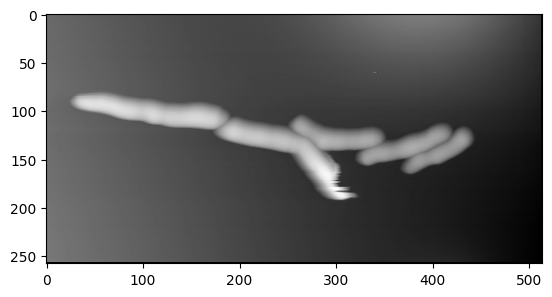

In [5]:
#| fig-cap: "Raw image"

plt.imshow(img,cmap='gray')
plt.show()

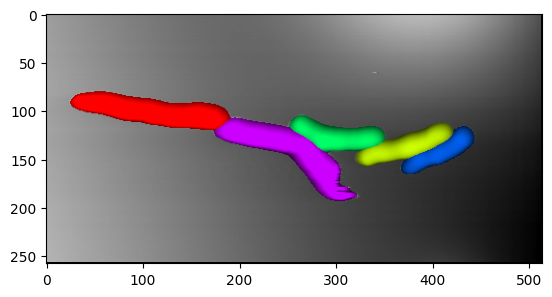

In [6]:
#| fig-cap: "Image with segmented masks overlaid"

mask_RGB = plot.mask_overlay(img,masks)
plt.imshow(mask_RGB)
plt.show()

## Centerline
Since we are interested in studying the variations of the cell diameter, we define height profile as the value of the cell height along the cell centerline. The cell centerline are computed using a skeletonization algorithm [@zhang1984fast,@lee1994building]. Here is an example of skeletonization 

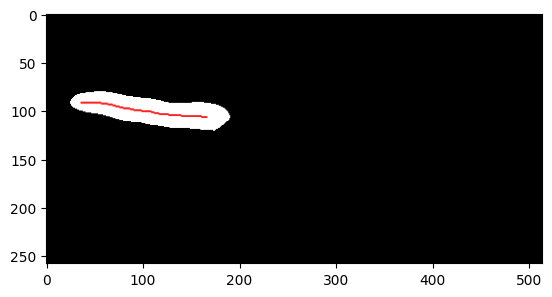

In [7]:
from skimage.morphology import skeletonize

# Selecting first mask
first_mask =  masks == 1

skel_img = skeletonize(first_mask, method='lee')  
skel = np.argwhere(skel_img)
plt.imshow(first_mask, cmap='gray')

plt.scatter(skel[:,1], skel[:,0], 0.5*np.ones(np.shape(skel[:,0])), color='r', marker='.')
plt.show()

Depending on the masks shapes, centerlines may have branches :

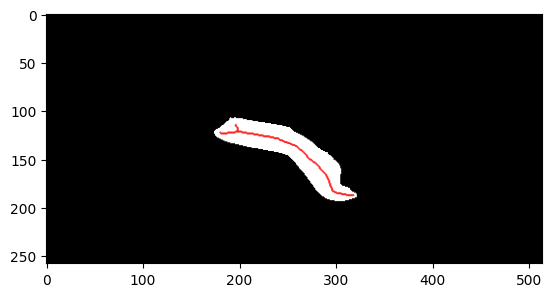

In [8]:
from skimage.morphology import skeletonize

# Selecting first mask
first_mask =  masks == 3

skel_img = skeletonize(first_mask)  #, method='lee'
skel = np.argwhere(skel_img)
plt.imshow(first_mask, cmap='gray')

plt.scatter(skel[:,1], skel[:,0], 0.5*np.ones(np.shape(skel[:,0])), color='r', marker='.')
plt.show()

In practice, centerlines are pruned and extended to the cell poles, in order to capture the cell length. Other geometrical properties such as masks centroids or outlines are computed as well.

![Final static processing results in real life data. White masks are excluded from the cell tracking algorithm (see part 2). Black dots are cell centroids. The yellow boxes represent artefacts cleaning.](Figure_3_quarto.png)

# References